In [1]:
import importlib
import rawpy
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import star_finder

In [2]:
pd.set_option("display.precision", 3)

In [3]:
importlib.reload(star_finder)
from star_finder import StarFinder

Scan stars from image

In [4]:
out_of_focus = r"C:\code\astrocam\outoffocus\Image741.nef"
in_focus = r"C:\code\astrocam\light\Image752.nef"
in_focus_753 = r"C:\code\astrocam\light\Image753.nef"

s = StarFinder()

ref_data = s.getStarData(in_focus)
tgt_data = s.getStarData(in_focus_753)
ref_image, df_ref = ref_data["image"], ref_data["stars"]
tgt_image, df_tgt = tgt_data["image"], tgt_data["stars"]


Calculating FWHM: 100%|██████████| 36/36 [00:00<00:00, 47.23it/s]


In [5]:
df_ref

,area,cluster_cx,cluster_cy,iwc_cx,iwc_cy,gaussian_cx,gaussian_cy,box,tile_4,tile_32,fwhm_x,fwhm_y
0,43,560.837,1.907,2.001,1.001,3.420,0.886,"[556, 0, 566, 5]",140,18,5.413,8.334
1,88,2968.920,180.602,4.999,5.001,4.949,6.257,"[2964, 175, 2974, 186]",49252,903,7.564,7.594
2,70,2920.400,182.100,3.999,4.001,3.766,5.822,"[2916, 177, 2925, 187]",50318,901,7.289,7.088
3,206,2233.985,241.913,7.001,9.001,8.208,10.927,"[2226, 233, 2242, 251]",65238,1150,9.667,11.250
4,49,679.000,495.000,4.999,2.001,5.044,3.993,"[675, 491, 683, 499]",133842,2046,5.980,6.185
5,151,1154.437,579.517,6.001,7.001,7.610,8.493,"[1148, 572, 1161, 587]",156599,2466,8.151,8.774
6,49,2172.000,793.000,4.999,3.001,4.921,5.298,"[2168, 789, 2176, 797]",213987,3443,4.918,6.874
7,56,1510.000,864.500,4.999,4.001,4.767,5.836,"[1506, 860, 1514, 869]",233226,3692,4.423,5.900
8,177,1913.994,933.684,6.001,7.001,7.371,8.599,"[1907, 926, 1921, 942]",251652,3975,8.971,9.941
9,63,2265.556,951.444,5.999,4.001,5.339,5.450,"[2261, 947, 2270, 956]",257130,4121,4.698,5.933


Make triangles with stars as vertices
- For each triangle, store the ratio of two shorter sides to the longest side as fX & fY

In [9]:
from itertools import combinations, product
import math

def getTriangles(df):

    # Cache distances between every pair of stars
    starDistances = {}
    for c in combinations(df.index, 2):
        assert(c[1] > c[0])
        key = (c[0], c[1])
        x1, y1 = df.loc[c[0],['centroid_x', 'centroid_y']]
        x2, y2 = df.loc[c[1],['centroid_x', 'centroid_y']]
        starDistances[key] = math.sqrt((x2-x1)**2 + (y2-y1)**2)

    vTriangles = []
    for i,j,k in combinations(df.index, 3):
        vDistances = sorted([starDistances[(i,j)], starDistances[(j,k)], starDistances[(i,k)]])

        if vDistances[2] > 0:
            fX = vDistances[1]/vDistances[2]
            fY = vDistances[0]/vDistances[2]

            # Filter
            if (fX < 0.9):
                # Add to the triangle list
                vTriangles.append({"s1":i, "s2":j, "s3":k, "fX":fX, "fY":fY})

    vTriangles = sorted(vTriangles, key=lambda x: x["fX"])
    return pd.DataFrame(vTriangles)


In [10]:
tri_ref = getTriangles(df_ref)
print(len(tri_ref))

5468


In [11]:
tri_tgt = getTriangles(df_tgt)
print(len(tri_tgt))

4960


Collect triangle match counts

In [12]:
TRIANGLETOLERANCE = 1e-4
votes = np.zeros((len(df_ref)+1, len(df_tgt)+1), dtype=np.uint32)

for tgt in tri_tgt.itertuples():
    ref_matches = tri_ref[(tri_ref.fX >= tgt.fX) & (tri_ref.fX <= tgt.fX + TRIANGLETOLERANCE)]
    ref_matches = ref_matches[(ref_matches.fX-tgt.fX)**2 + (ref_matches.fY-tgt.fY)**2 < TRIANGLETOLERANCE**2]
    for ref in ref_matches.itertuples():
        for a,b in product([ref.s1, ref.s2, ref.s3], [tgt.s1, tgt.s2, tgt.s3]):
            votes[int(a), b] += 1

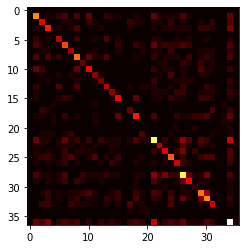

In [13]:
plt.imshow(votes, cmap='hot')
plt.show()

Produce sorted list of star pairs with highest votes

In [14]:
vVotingPairs = np.column_stack(np.unravel_index(np.argsort(votes, axis=None), shape=votes.shape))[::-1]

In [15]:
len(vVotingPairs)

1332

Select only those votes that are higher than a treshold

In [16]:
x,y = vVotingPairs[len(df_tgt)]
cutoff = max(1, votes[x,y])
print(f"Vote cutoff threshold: {cutoff}")
topVotePairs = list(filter(lambda r: votes[r[0],r[1]] > cutoff, vVotingPairs))

Vote cutoff threshold: 5


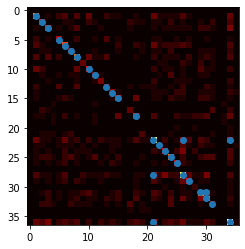

In [17]:
plt.imshow(votes, cmap='hot')
plt.scatter([x[1] for x in topVotePairs], [x[0] for x in topVotePairs])
plt.show()

In [18]:
len(topVotePairs)

29

In [19]:
matches = []
for vp in topVotePairs:
    s1, s2 = vp
    if s1 == 0 or s2 == 0:
        continue
    if np.argmax(votes[:, s2]) != s1 or np.argmax(votes[s1, :]) != s2:
        continue
    matches.append((s1, s2))

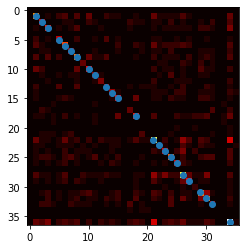

In [20]:
plt.imshow(votes, cmap='hot')
plt.scatter([x[1] for x in matches], [x[0] for x in matches])
plt.show()

Plot star match results

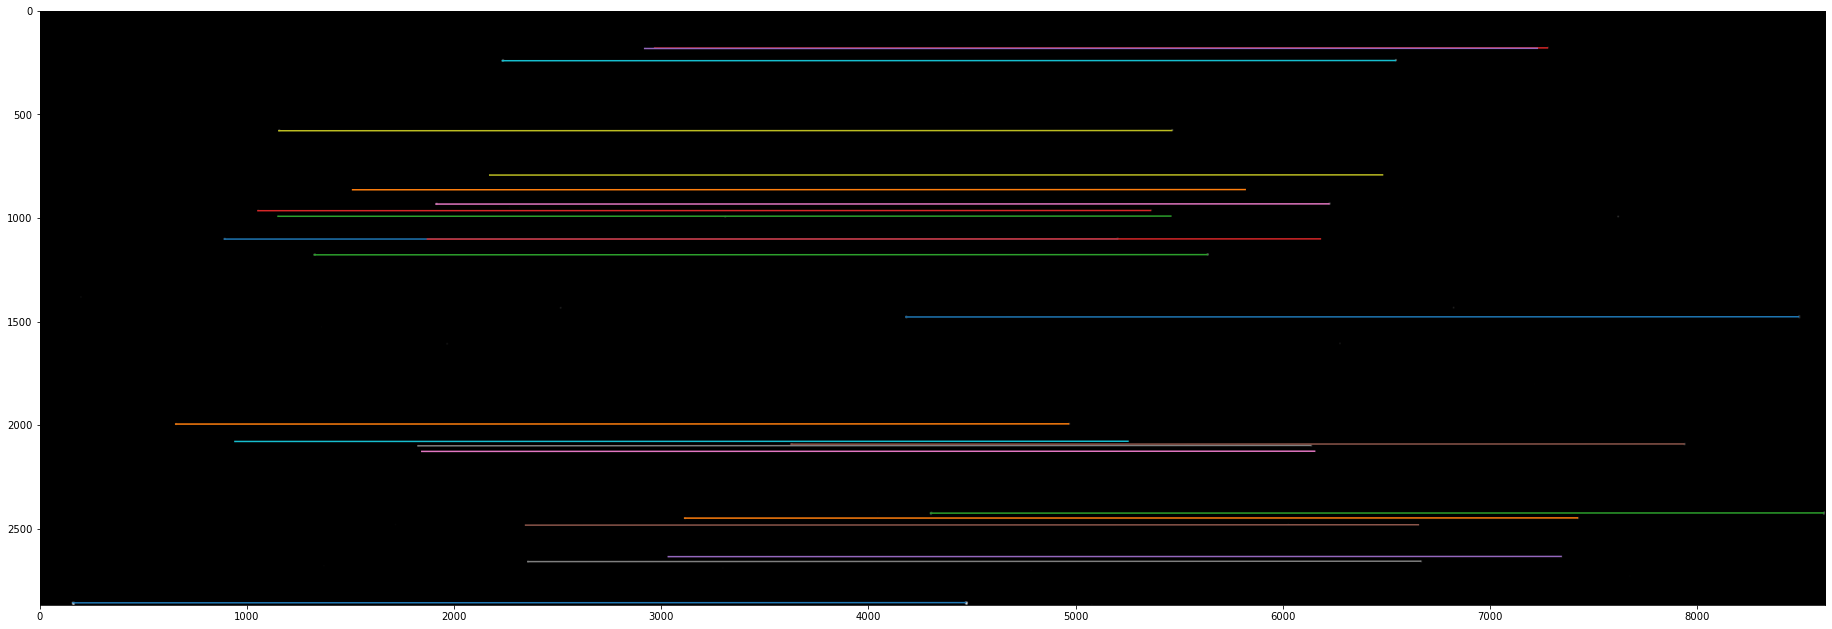

In [21]:
img = np.column_stack((ref_image,tgt_image))
fig = plt.figure(figsize=(32,16))
plt.imshow(img, cmap='gray')

for s1,s2 in matches:
    x1,y1 = df_ref.loc[s1, ['centroid_x', 'centroid_y']]
    x2,y2 = df_tgt.loc[s2, ['centroid_x', 'centroid_y']]
    x2 += ref_image.shape[1]
    xs = [int(x1), int(x2)]
    ys = [int(y1), int(y2)]
    plt.plot(xs, ys)

plt.show()

In [22]:
matches_ref, matches_tgt = [m[0] for m in matches], [m[1] for m in matches]

matches_ref = df_ref[df_ref.index.isin(matches_ref)].reset_index()
matches_tgt = df_tgt[df_tgt.index.isin(matches_tgt)].reset_index()

In [23]:
matches_ref.head()

,index,area,centroid_x,centroid_y,box,tile_4,tile_32,fwhm_x,fwhm_y
0,1,88,2968.920,180.602,"[2964, 175, 2974, 186]",49252,903,7.564,7.594
1,2,70,2920.400,182.100,"[2916, 177, 2925, 187]",50318,901,7.289,7.088
2,3,206,2233.985,241.913,"[2226, 233, 2242, 251]",65238,1150,9.667,11.250
3,5,151,1154.437,579.517,"[1148, 572, 1161, 587]",156599,2466,8.151,8.774
4,6,49,2172.000,793.000,"[2168, 789, 2176, 797]",213987,3443,4.918,6.874


In [24]:
matches_tgt.head()

,index,area,centroid_x,centroid_y,box,tile_4,tile_32,fwhm_x,fwhm_y
0,1,70,2968.600,179.900,"[2964, 175, 2973, 185]",49252,903,7.693,6.978
1,2,49,2919.000,181.000,"[2915, 177, 2923, 185]",49240,901,7.764,6.989
2,3,155,2233.594,240.658,"[2226, 234, 2241, 247]",65238,1150,9.699,12.156
3,5,143,1154.175,578.294,"[1147, 572, 1161, 585]",156599,2466,8.103,8.929
4,6,56,2172.000,792.500,"[2168, 788, 2176, 797]",213987,3443,4.710,6.240


In [25]:
frames = pd.merge(left=matches_ref, right=matches_tgt, left_index=True, right_index=True, suffixes=["_ref", "_tgt"])

In [26]:
frames.head()

,index_ref,area_ref,centroid_x_ref,centroid_y_ref,box_ref,tile_4_ref,tile_32_ref,fwhm_x_ref,fwhm_y_ref,index_tgt,area_tgt,centroid_x_tgt,centroid_y_tgt,box_tgt,tile_4_tgt,tile_32_tgt,fwhm_x_tgt,fwhm_y_tgt
0,1,88,2968.920,180.602,"[2964, 175, 2974, 186]",49252,903,7.564,7.594,1,70,2968.600,179.900,"[2964, 175, 2973, 185]",49252,903,7.693,6.978
1,2,70,2920.400,182.100,"[2916, 177, 2925, 187]",50318,901,7.289,7.088,2,49,2919.000,181.000,"[2915, 177, 2923, 185]",49240,901,7.764,6.989
2,3,206,2233.985,241.913,"[2226, 233, 2242, 251]",65238,1150,9.667,11.250,3,155,2233.594,240.658,"[2226, 234, 2241, 247]",65238,1150,9.699,12.156
3,5,151,1154.437,579.517,"[1148, 572, 1161, 587]",156599,2466,8.151,8.774,5,143,1154.175,578.294,"[1147, 572, 1161, 585]",156599,2466,8.103,8.929
4,6,49,2172.000,793.000,"[2168, 789, 2176, 797]",213987,3443,4.918,6.874,6,56,2172.000,792.500,"[2168, 788, 2176, 797]",213987,3443,4.710,6.240


In [27]:
frames['fwhm_x_diff'] = frames.fwhm_x_ref - frames.fwhm_x_tgt
frames['fwhm_y_diff'] = frames.fwhm_y_ref - frames.fwhm_y_tgt

In [28]:
frames.head()

,index_ref,area_ref,centroid_x_ref,centroid_y_ref,box_ref,tile_4_ref,tile_32_ref,fwhm_x_ref,fwhm_y_ref,index_tgt,area_tgt,centroid_x_tgt,centroid_y_tgt,box_tgt,tile_4_tgt,tile_32_tgt,fwhm_x_tgt,fwhm_y_tgt,fwhm_x_diff,fwhm_y_diff
0,1,88,2968.920,180.602,"[2964, 175, 2974, 186]",49252,903,7.564,7.594,1,70,2968.600,179.900,"[2964, 175, 2973, 185]",49252,903,7.693,6.978,-0.129,0.616
1,2,70,2920.400,182.100,"[2916, 177, 2925, 187]",50318,901,7.289,7.088,2,49,2919.000,181.000,"[2915, 177, 2923, 185]",49240,901,7.764,6.989,-0.476,0.099
2,3,206,2233.985,241.913,"[2226, 233, 2242, 251]",65238,1150,9.667,11.250,3,155,2233.594,240.658,"[2226, 234, 2241, 247]",65238,1150,9.699,12.156,-0.032,-0.906
3,5,151,1154.437,579.517,"[1148, 572, 1161, 587]",156599,2466,8.151,8.774,5,143,1154.175,578.294,"[1147, 572, 1161, 585]",156599,2466,8.103,8.929,0.047,-0.155
4,6,49,2172.000,793.000,"[2168, 789, 2176, 797]",213987,3443,4.918,6.874,6,56,2172.000,792.500,"[2168, 788, 2176, 797]",213987,3443,4.710,6.240,0.208,0.634


In [29]:
frames.fwhm_x_diff.mean(), frames.fwhm_y_diff.mean()

(-0.0075611411815530065, 0.08899254977467126)

In [30]:
frames.fwhm_x_diff.std(), frames.fwhm_y_diff.std()

(0.48127260003903893, 0.410123057791831)